# Data Preprocessing and Feature Engineering
## Module 5, Lab 3: Preparing Data for Machine Learning

Raw data is rarely ready for machine learning algorithms. This lab teaches you how to clean, transform, and engineer features to create high-quality datasets that lead to better model performance.

### Learning Objectives
By the end of this lab, you will be able to:
- Handle missing values using various strategies
- Encode categorical variables for machine learning
- Scale and normalize numerical features
- Detect and handle outliers appropriately
- Create new features through feature engineering
- Build preprocessing pipelines for reproducibility

### Why This Matters
Data preprocessing often takes 80% of a data scientist's time, but it's crucial for model success. Poor data preparation leads to poor models, regardless of the algorithm used.

## Setup and Data Loading

In [1]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


### Creating a Realistic Dataset with Data Quality Issues
We'll create a dataset that mimics real-world data problems you'll encounter.

In [32]:
# Create a realistic employee dataset with various data quality issues
np.random.seed(42)
n_employees = 1000

# Generate base employee data
employee_data = {
    'employee_id': range(1, n_employees + 1),
    'age': np.random.normal(40, 15, n_employees),
    'years_experience': np.random.exponential(5, n_employees),
    'education_level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 
                                       n_employees, p=[0.20, 0.4, 0.30, 0.10]),
    'department': np.random.choice(['Engineering', 'Sales', 'Marketing', 'HR', 'Finance'], 
                                  n_employees, p=[0.30, 0.20, 0.30, 0.15, 0.05]),
    'job_level': np.random.choice(['Junior', 'Mid', 'Senior', 'Lead'], 
                                 n_employees, p=[0.25, 0.35, 0.30, 0.10]),
    'location': np.random.choice(['New York', 'San Francisco', 'Chicago', 'Austin', 'Remote'], 
                                n_employees, p=[0.30, 0.25, 0.25, 0.10, 0.10]),
    'performance_score': np.random.normal(8.0, 2.0, n_employees),
    'hours_per_week': np.random.normal(40, 10, n_employees),
    'projects_completed': np.random.poisson(10, n_employees),
    'training_hours': np.random.gamma(4, 12, n_employees)
}

# Create DataFrame
df = pd.DataFrame(employee_data)

# Add realistic constraints
df['age'] = np.clip(df['age'], 20, 70)
df['years_experience'] = np.clip(df['years_experience'], 0, df['age'] - 20)
df['performance_score'] = np.clip(df['performance_score'], 1, 10)
df['hours_per_week'] = np.clip(df['hours_per_week'], 25, 50)

# Create salary based on realistic factors (this will be our target variable)
base_salary = 60000
education_bonus = {'High School': 0, 'Bachelor': 20000, 'Master': 30000, 'PhD': 45000}
level_bonus = {'Junior': 0, 'Mid': 25000, 'Senior': 45000, 'Lead': 75000}
dept_bonus = {'Engineering': 20000, 'Sales': 15000, 'Marketing': 5000, 'HR': 0, 'Finance': 6000}
location_bonus = {'New York': 25000, 'San Francisco': 30000, 'Chicago': 6000, 'Austin': 10000, 'Remote': 0}

df['salary'] = (base_salary + 
                df['education_level'].map(education_bonus) +
                df['job_level'].map(level_bonus) +
                df['department'].map(dept_bonus) +
                df['location'].map(location_bonus) +
                df['years_experience'] * 2000 +
                df['performance_score'] * 3000 +
                np.random.normal(0, 10000, n_employees))

df['salary'] = np.maximum(df['salary'], 35000)  # Minimum salary

print(f"Dataset created with {len(df)} employees")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset created with 1000 employees
Dataset shape: (1000, 12)


,employee_id,age,years_experience,education_level,department,job_level,location,performance_score,hours_per_week,projects_completed,training_hours,salary
0,1,47.450712,0.916506,Bachelor,Marketing,Junior,San Francisco,6.688625,50.000000,16,34.712528,128605.681291
1,2,37.926035,0.552244,High School,Engineering,Junior,Chicago,7.528578,41.259014,9,73.505014,115605.930888
2,3,49.715328,5.058921,High School,Sales,Mid,San Francisco,6.121074,48.511241,15,43.724287,154668.688822
3,4,62.845448,6.128975,Bachelor,HR,Mid,New York,10.000000,50.000000,10,38.721783,170186.332504
4,5,36.487699,0.160479,Master,Sales,Junior,Chicago,7.411088,43.379556,7,43.328989,146255.103174


### Introducing Realistic Data Quality Issues

In [33]:
# Introduce missing values (realistic patterns)
# Performance scores might be missing for new employees
new_employee_mask = df['years_experience'] < 0.5
df.loc[new_employee_mask & (np.random.random(len(df)) < 0.3), 'performance_score'] = np.nan

# Training hours might be missing randomly
missing_training = np.random.choice(df.index, size=80, replace=False)
df.loc[missing_training, 'training_hours'] = np.nan

# Some education levels might be missing
missing_education = np.random.choice(df.index, size=30, replace=False)
df.loc[missing_education, 'education_level'] = np.nan

# Add some outliers
# Extremely high performers
outlier_indices = np.random.choice(df.index, size=10, replace=False)
df.loc[outlier_indices, 'hours_per_week'] = np.random.uniform(70, 80, 10)
df.loc[outlier_indices, 'projects_completed'] = np.random.uniform(25, 35, 10)

# Add some inconsistent data
# Some employees with PhD but very low experience (career changers)
career_changer_indices = np.random.choice(df[df['education_level'] == 'PhD'].index, size=5, replace=False)
df.loc[career_changer_indices, 'years_experience'] = np.random.uniform(0, 2, 5)

# Add some duplicate-like entries (same person, different records)
duplicate_base = df.sample(3).copy()
duplicate_base['employee_id'] = range(n_employees + 1, n_employees + 4)
# Slightly modify some values to simulate data entry errors
duplicate_base['age'] += np.random.randint(-1, 2, 3)
duplicate_base['salary'] += np.random.randint(-5000, 5000, 3)
df = pd.concat([df, duplicate_base], ignore_index=True)

print("Data quality issues introduced:")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Total records: {len(df)}")
print("\nMissing values by column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Data quality issues introduced:
Missing values: 167
Total records: 1003

Missing values by column:
education_level      30
performance_score    57
training_hours       80
dtype: int64


## Step 1: Data Quality Assessment
Before preprocessing, let's understand what we're working with.

In [35]:
# Comprehensive data quality report
def data_quality_report(df):
    print("=== DATA QUALITY REPORT ===")
    print(f"\n📊 Dataset Overview:")
    print(f"   • Shape: {df.shape}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    
    print(f"\n🔍 Missing Values:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    for col in missing_data[missing_data > 0].index:
        print(f"   • {col}: {missing_data[col]} ({missing_percent[col]:.1f}%)")
    
    print(f"\n📈 Data Types:")
    print(f"   • Numerical columns: {len(df.select_dtypes(include=[np.number]).columns)}")
    print(f"   • Categorical columns: {len(df.select_dtypes(include=['object']).columns)}")
    
    print(f"\n🎯 Potential Issues:")
    # Check for duplicates
    duplicates = len(df) - len(df.drop_duplicates())
    if duplicates > 0:
        print(f"   • Duplicate rows: {duplicates}")
    
    # Check for outliers in numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = len(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
        if outliers > 0:
            print(f"   • {col} outliers: {outliers} ({outliers/len(df)*100:.1f}%)")

data_quality_report(df)

=== DATA QUALITY REPORT ===

📊 Dataset Overview:
   • Shape: (1003, 12)
   • Memory usage: 313.1 KB

🔍 Missing Values:
   • education_level: 30 (3.0%)
   • performance_score: 57 (5.7%)
   • training_hours: 80 (8.0%)

📈 Data Types:
   • Numerical columns: 8
   • Categorical columns: 4

🎯 Potential Issues:
   • years_experience outliers: 34 (3.4%)
   • performance_score outliers: 3 (0.3%)
   • hours_per_week outliers: 10 (1.0%)
   • projects_completed outliers: 16 (1.6%)
   • training_hours outliers: 19 (1.9%)
   • salary outliers: 1 (0.1%)


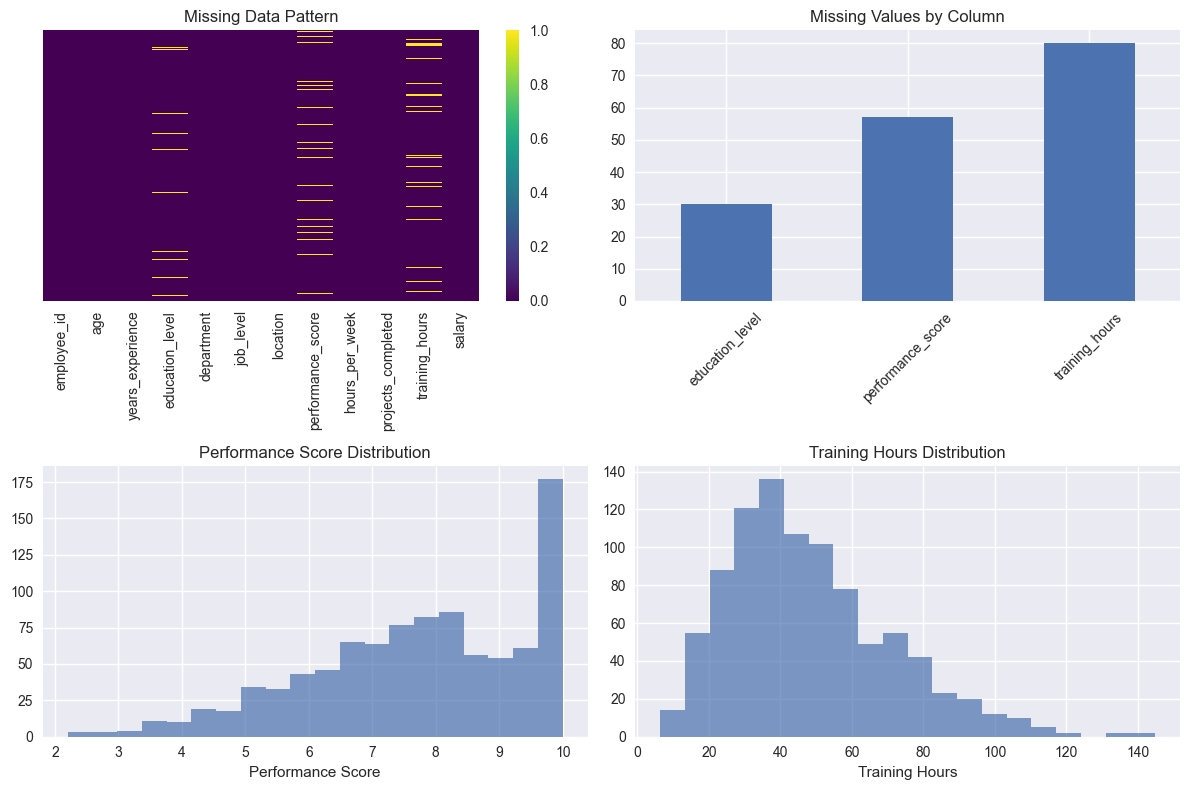

In [36]:
# Visualize missing data patterns
plt.figure(figsize=(12, 8))

# Missing data heatmap
plt.subplot(2, 2, 1)
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern')

# Missing data bar plot
plt.subplot(2, 2, 2)
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts.plot(kind='bar')
plt.title('Missing Values by Column')
plt.xticks(rotation=45)

# Distribution of numerical variables with missing values
plt.subplot(2, 2, 3)
df['performance_score'].hist(bins=20, alpha=0.7)
plt.title('Performance Score Distribution')
plt.xlabel('Performance Score')

plt.subplot(2, 2, 4)
df['training_hours'].hist(bins=20, alpha=0.7)
plt.title('Training Hours Distribution')
plt.xlabel('Training Hours')

plt.tight_layout()
plt.show()

## Step 2: Handling Missing Values
Different strategies work better for different types of missing data.

### 2.1 Understanding Missing Data Patterns

In [37]:
# Analyze missing data patterns
print("Missing Data Analysis:")
print("\n1. Performance Score Missing Pattern:")
missing_perf = df[df['performance_score'].isnull()]
print(f"   • Average years of experience: {missing_perf['years_experience'].mean():.2f}")
print(f"   • Most common job level: {missing_perf['job_level'].mode().iloc[0]}")

print("\n2. Training Hours Missing Pattern:")
missing_training = df[df['training_hours'].isnull()]
print(f"   • Average age: {missing_training['age'].mean():.2f}")
print(f"   • Department distribution:")
print(missing_training['department'].value_counts())

print("\n3. Education Level Missing Pattern:")
missing_edu = df[df['education_level'].isnull()]
print(f"   • Average salary: ${missing_edu['salary'].mean():.0f}")
print(f"   • Average years experience: {missing_edu['years_experience'].mean():.2f}")

Missing Data Analysis:

1. Performance Score Missing Pattern:
   • Average years of experience: 0.14
   • Most common job level: Mid

2. Training Hours Missing Pattern:
   • Average age: 36.76
   • Department distribution:
department
Engineering    28
Marketing      22
Sales          18
HR              9
Finance         3
Name: count, dtype: int64

3. Education Level Missing Pattern:
   • Average salary: $162508
   • Average years experience: 5.04


### 2.2 Imputation Strategies

In [38]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Applying different imputation strategies...")

# Strategy 1: Mean imputation for performance_score (numerical)
# But let's be smarter - use group mean based on job level
performance_means = df_processed.groupby('job_level')['performance_score'].mean()
print("\nPerformance score means by job level:")
print(performance_means)

for level in performance_means.index:
    mask = (df_processed['job_level'] == level) & (df_processed['performance_score'].isnull())
    df_processed.loc[mask, 'performance_score'] = performance_means[level]

# Strategy 2: Median imputation for training_hours (skewed distribution)
training_median = df_processed['training_hours'].median()
df_processed['training_hours'].fillna(training_median, inplace=True)
print(f"\nFilled training hours with median: {training_median:.1f}")

# Strategy 3: Mode imputation for education_level (categorical)
education_mode = df_processed['education_level'].mode().iloc[0]
df_processed['education_level'].fillna(education_mode, inplace=True)
print(f"Filled education level with mode: {education_mode}")

print(f"\nMissing values after imputation: {df_processed.isnull().sum().sum()}")

Applying different imputation strategies...

Performance score means by job level:
job_level
Junior    7.894668
Lead      7.588010
Mid       7.662203
Senior    7.662273
Name: performance_score, dtype: float64

Filled training hours with median: 43.8
Filled education level with mode: Bachelor

Missing values after imputation: 0


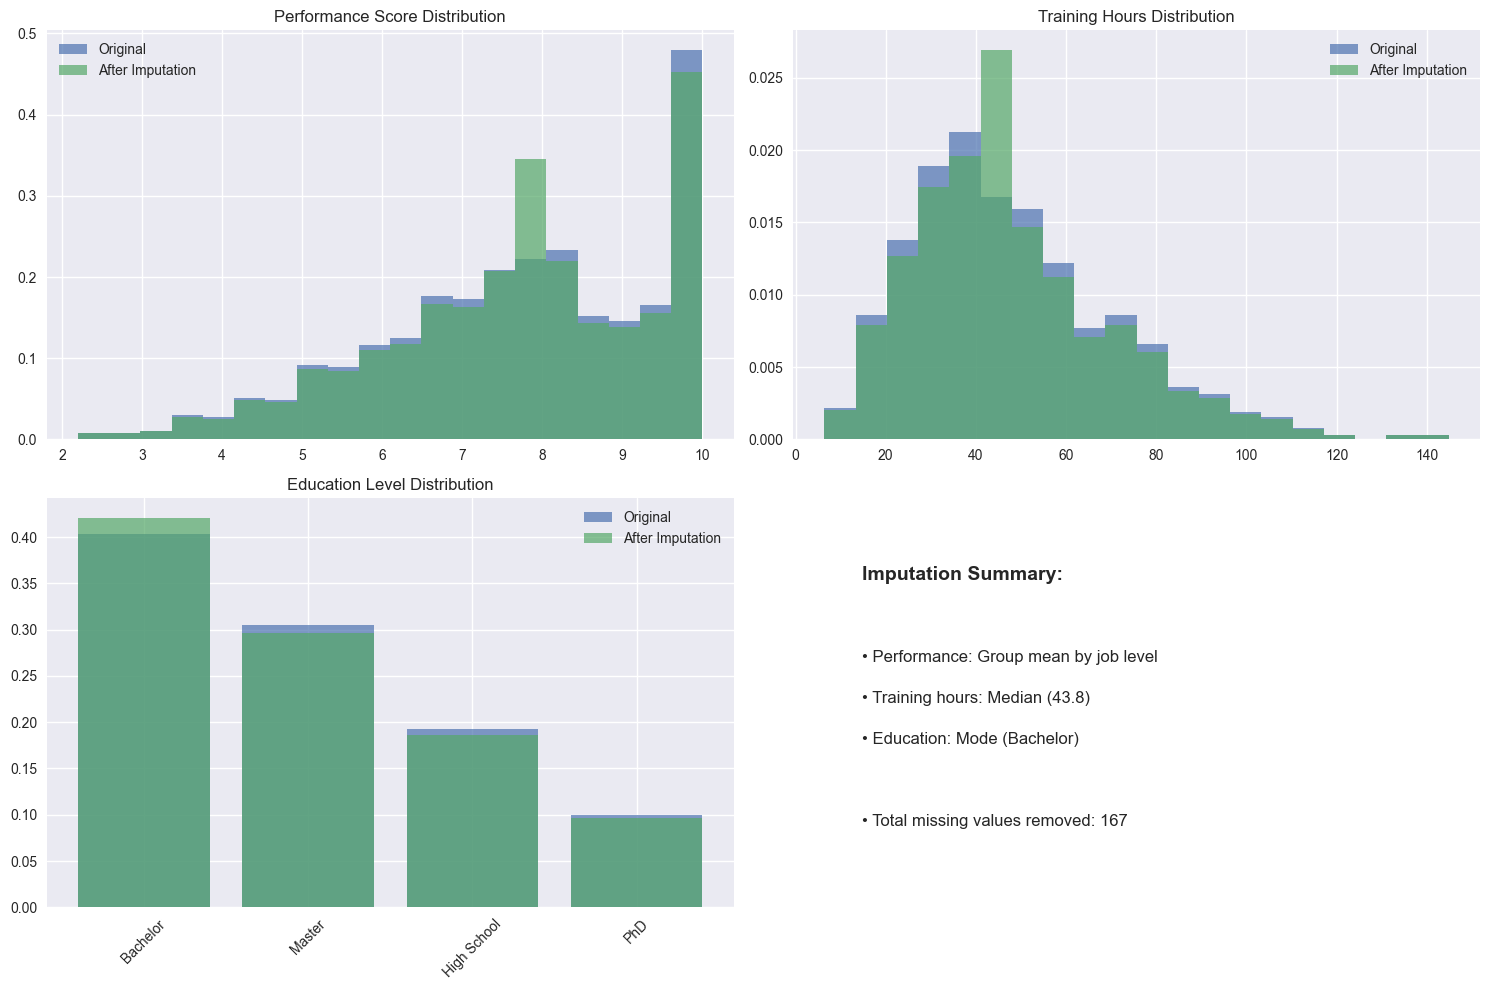

In [39]:
# Compare distributions before and after imputation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Performance score
axes[0, 0].hist(df['performance_score'].dropna(), bins=20, alpha=0.7, label='Original', density=True)
axes[0, 0].hist(df_processed['performance_score'], bins=20, alpha=0.7, label='After Imputation', density=True)
axes[0, 0].set_title('Performance Score Distribution')
axes[0, 0].legend()

# Training hours
axes[0, 1].hist(df['training_hours'].dropna(), bins=20, alpha=0.7, label='Original', density=True)
axes[0, 1].hist(df_processed['training_hours'], bins=20, alpha=0.7, label='After Imputation', density=True)
axes[0, 1].set_title('Training Hours Distribution')
axes[0, 1].legend()

# Education level
original_edu = df['education_level'].value_counts(normalize=True)
imputed_edu = df_processed['education_level'].value_counts(normalize=True)
axes[1, 0].bar(range(len(original_edu)), original_edu.values, alpha=0.7, label='Original')
axes[1, 0].bar(range(len(imputed_edu)), imputed_edu.values, alpha=0.7, label='After Imputation')
axes[1, 0].set_xticks(range(len(original_edu)))
axes[1, 0].set_xticklabels(original_edu.index, rotation=45)
axes[1, 0].set_title('Education Level Distribution')
axes[1, 0].legend()

# Summary
axes[1, 1].text(0.1, 0.8, 'Imputation Summary:', fontsize=14, fontweight='bold')
axes[1, 1].text(0.1, 0.6, f'• Performance: Group mean by job level', fontsize=12)
axes[1, 1].text(0.1, 0.5, f'• Training hours: Median ({training_median:.1f})', fontsize=12)
axes[1, 1].text(0.1, 0.4, f'• Education: Mode ({education_mode})', fontsize=12)
axes[1, 1].text(0.1, 0.2, f'• Total missing values removed: {df.isnull().sum().sum()}', fontsize=12)
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Step 3: Encoding Categorical Variables
Machine learning algorithms work with numbers, so we need to convert categorical data.

In [40]:
# Identify categorical columns
categorical_columns = ['education_level', 'department', 'job_level', 'location']
print("Categorical columns to encode:")
for col in categorical_columns:
    print(f"• {col}: {df_processed[col].nunique()} unique values")
    print(f"  Values: {list(df_processed[col].unique())}")
    print()

Categorical columns to encode:
• education_level: 4 unique values
  Values: ['Bachelor', 'High School', 'Master', 'PhD']

• department: 5 unique values
  Values: ['Marketing', 'Engineering', 'Sales', 'HR', 'Finance']

• job_level: 4 unique values
  Values: ['Junior', 'Mid', 'Lead', 'Senior']

• location: 5 unique values
  Values: ['San Francisco', 'Chicago', 'New York', 'Austin', 'Remote']



### 3.1 Ordinal Encoding (for ordered categories)

In [41]:
# Education level has a natural order
education_order = ['High School', 'Bachelor', 'Master', 'PhD']
education_mapping = {level: i for i, level in enumerate(education_order)}
df_processed['education_level_encoded'] = df_processed['education_level'].map(education_mapping)

# Job level also has a natural order
job_order = ['Junior', 'Mid', 'Senior', 'Lead']
job_mapping = {level: i for i, level in enumerate(job_order)}
df_processed['job_level_encoded'] = df_processed['job_level'].map(job_mapping)

print("Ordinal Encoding Applied:")
print("\nEducation Level Mapping:")
for original, encoded in education_mapping.items():
    print(f"  {original} → {encoded}")

print("\nJob Level Mapping:")
for original, encoded in job_mapping.items():
    print(f"  {original} → {encoded}")

Ordinal Encoding Applied:

Education Level Mapping:
  High School → 0
  Bachelor → 1
  Master → 2
  PhD → 3

Job Level Mapping:
  Junior → 0
  Mid → 1
  Senior → 2
  Lead → 3


### 3.2 One-Hot Encoding (for nominal categories)

In [42]:
# Department and location don't have natural order - use one-hot encoding
# Create dummy variables
department_dummies = pd.get_dummies(df_processed['department'], prefix='dept')
location_dummies = pd.get_dummies(df_processed['location'], prefix='loc')

print("One-Hot Encoding Applied:")
print(f"\nDepartment columns created: {list(department_dummies.columns)}")
print(f"Location columns created: {list(location_dummies.columns)}")

# Add to dataframe
df_processed = pd.concat([df_processed, department_dummies, location_dummies], axis=1)

print(f"\nDataset shape after encoding: {df_processed.shape}")

One-Hot Encoding Applied:

Department columns created: ['dept_Engineering', 'dept_Finance', 'dept_HR', 'dept_Marketing', 'dept_Sales']
Location columns created: ['loc_Austin', 'loc_Chicago', 'loc_New York', 'loc_Remote', 'loc_San Francisco']

Dataset shape after encoding: (1003, 24)


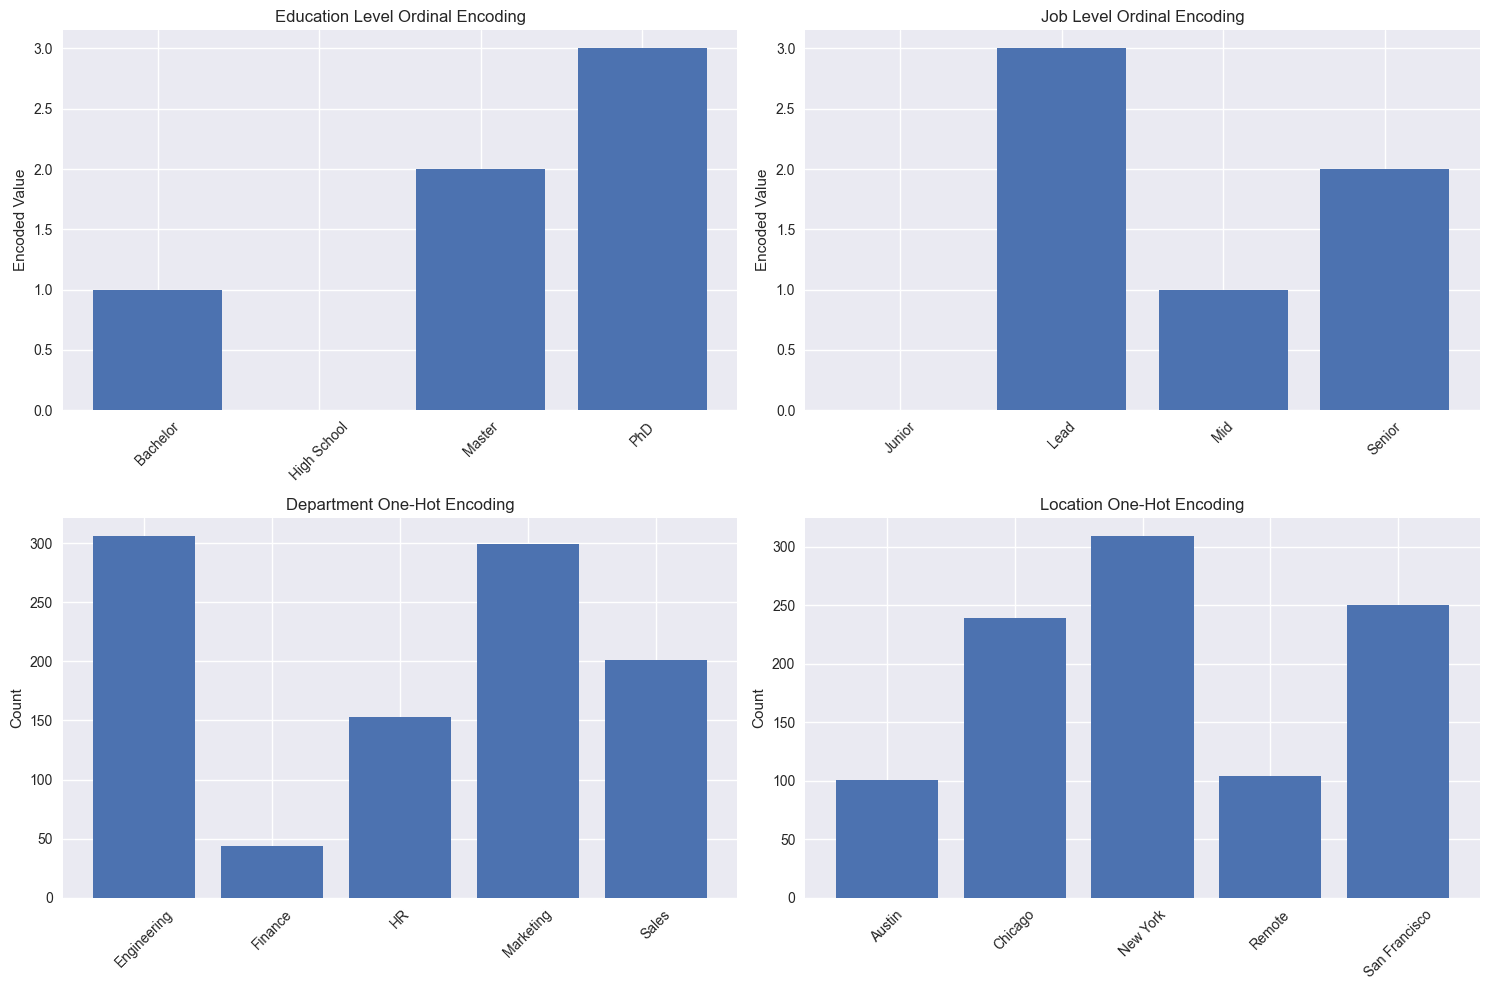

In [43]:
# Visualize the encoding results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Education level encoding
education_comparison = pd.DataFrame({
    'Original': df_processed['education_level'].value_counts(),
    'Encoded': df_processed.groupby('education_level')['education_level_encoded'].first()
})
axes[0, 0].bar(education_comparison.index, education_comparison['Encoded'])
axes[0, 0].set_title('Education Level Ordinal Encoding')
axes[0, 0].set_ylabel('Encoded Value')
axes[0, 0].tick_params(axis='x', rotation=45)

# Job level encoding
job_comparison = pd.DataFrame({
    'Original': df_processed['job_level'].value_counts(),
    'Encoded': df_processed.groupby('job_level')['job_level_encoded'].first()
})
axes[0, 1].bar(job_comparison.index, job_comparison['Encoded'])
axes[0, 1].set_title('Job Level Ordinal Encoding')
axes[0, 1].set_ylabel('Encoded Value')
axes[0, 1].tick_params(axis='x', rotation=45)

# Department one-hot encoding
dept_cols = [col for col in df_processed.columns if col.startswith('dept_')]
dept_sums = df_processed[dept_cols].sum()
axes[1, 0].bar(range(len(dept_sums)), dept_sums.values)
axes[1, 0].set_xticks(range(len(dept_sums)))
axes[1, 0].set_xticklabels([col.replace('dept_', '') for col in dept_sums.index], rotation=45)
axes[1, 0].set_title('Department One-Hot Encoding')
axes[1, 0].set_ylabel('Count')

# Location one-hot encoding
loc_cols = [col for col in df_processed.columns if col.startswith('loc_')]
loc_sums = df_processed[loc_cols].sum()
axes[1, 1].bar(range(len(loc_sums)), loc_sums.values)
axes[1, 1].set_xticks(range(len(loc_sums)))
axes[1, 1].set_xticklabels([col.replace('loc_', '') for col in loc_sums.index], rotation=45)
axes[1, 1].set_title('Location One-Hot Encoding')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Step 4: Feature Scaling and Normalization
Different features have different scales, which can bias machine learning algorithms.

In [44]:
# Identify numerical columns for scaling
numerical_columns = ['age', 'years_experience', 'performance_score', 'hours_per_week', 
                    'projects_completed', 'training_hours', 'salary']

print("Numerical columns statistics before scaling:")
print(df_processed[numerical_columns].describe().round(2))

Numerical columns statistics before scaling:
           age  years_experience  performance_score  hours_per_week  \
count  1003.00           1003.00            1003.00         1003.00   
mean     40.65              4.23               7.72           39.51   
std      13.40              4.31               1.70            8.91   
min      20.00              0.00               2.20           25.00   
25%      30.31              0.92               6.69           32.50   
50%      40.39              3.03               7.77           39.68   
75%      49.72              6.28               9.10           47.05   
max      70.00             24.02              10.00           78.98   

       projects_completed  training_hours     salary  
count             1003.00         1003.00    1003.00  
mean                10.47           47.81  170677.64  
std                  3.74           22.05   33097.05  
min                  2.00            6.41   84200.73  
25%                  8.00           32.9

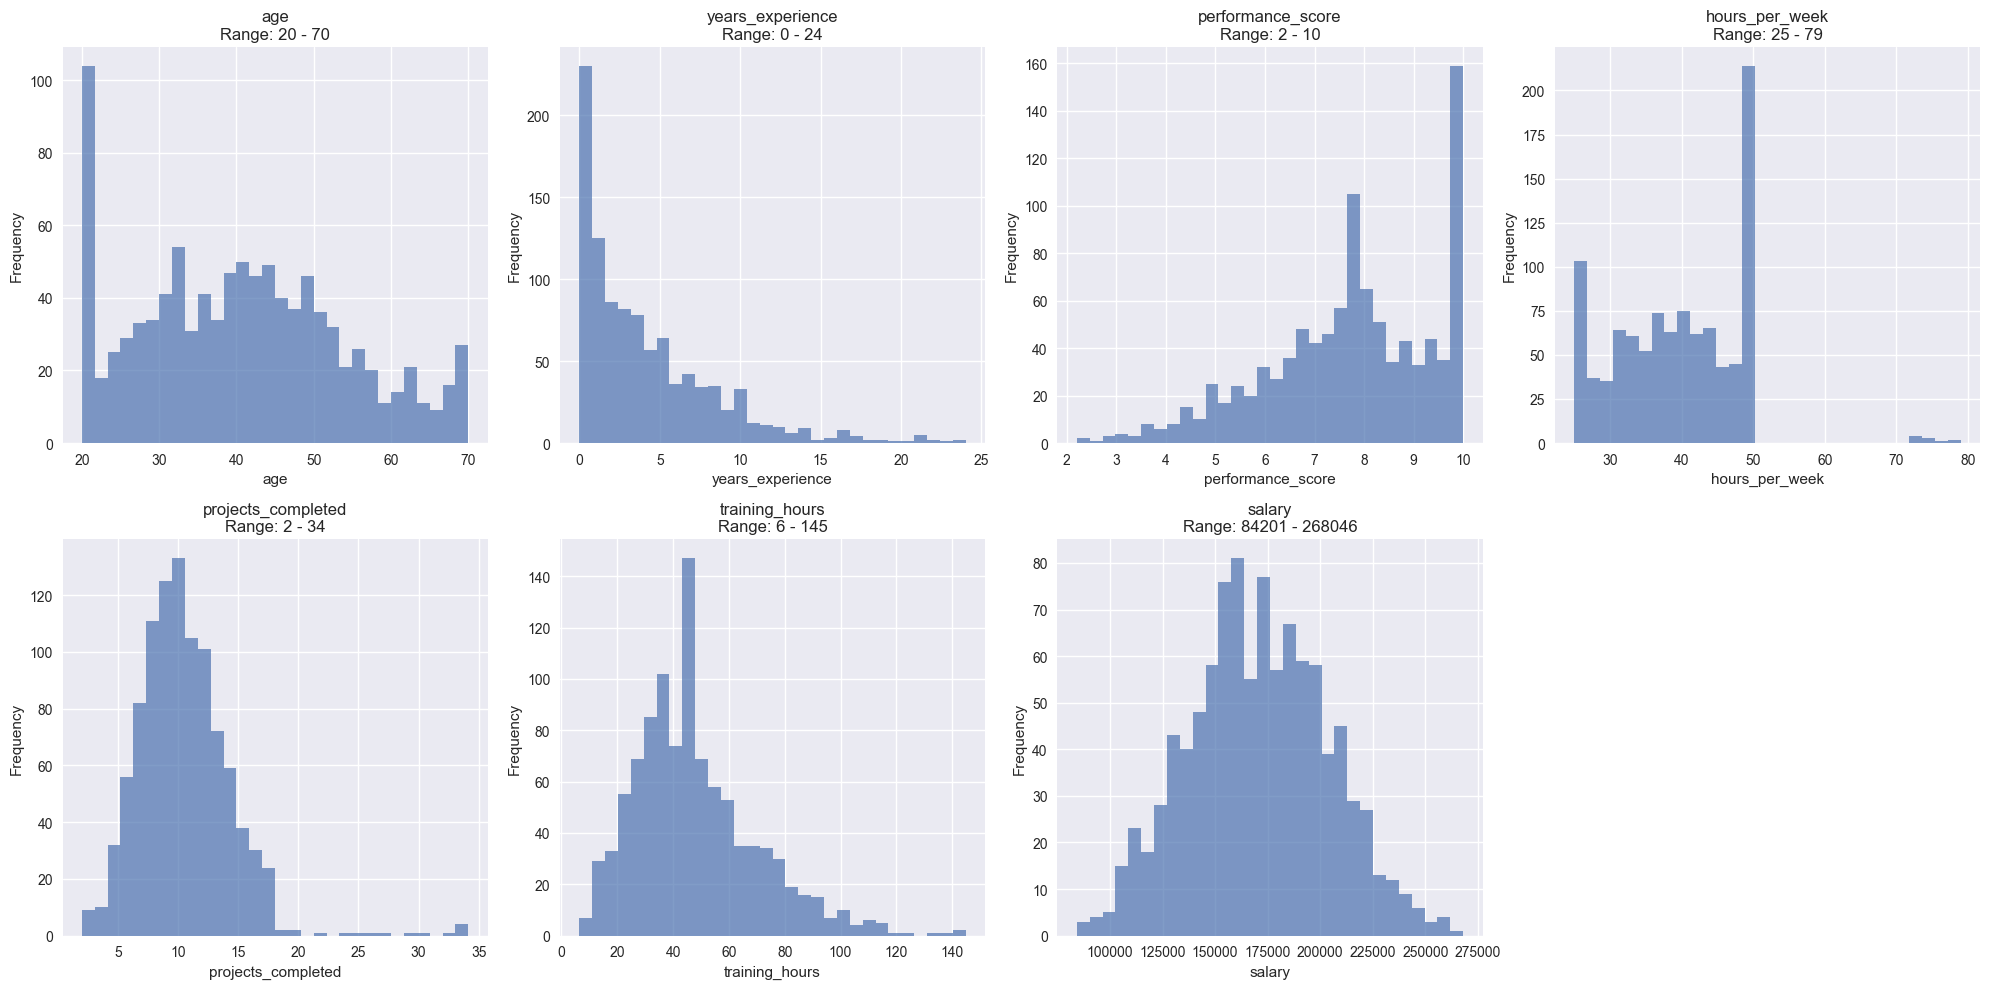

In [45]:
# Visualize the scale differences
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_columns):
    axes[i].hist(df_processed[col], bins=30, alpha=0.7)
    axes[i].set_title(f'{col}\nRange: {df_processed[col].min():.0f} - {df_processed[col].max():.0f}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove empty subplot
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

### 4.1 Standard Scaling (Z-score normalization)

In [46]:
# Apply StandardScaler (mean=0, std=1)
scaler_standard = StandardScaler()

# We'll exclude salary from scaling since it's our target variable
features_to_scale = [col for col in numerical_columns if col != 'salary']

# Fit and transform
df_standard_scaled = df_processed.copy()
df_standard_scaled[features_to_scale] = scaler_standard.fit_transform(df_processed[features_to_scale])

print("Standard Scaling Applied:")
print("\nFeatures scaled (mean=0, std=1):")
print(df_standard_scaled[features_to_scale].describe().round(3))

Standard Scaling Applied:

Features scaled (mean=0, std=1):
            age  years_experience  performance_score  hours_per_week  \
count  1003.000          1003.000           1003.000        1003.000   
mean     -0.000            -0.000              0.000          -0.000   
std       1.000             1.000              1.000           1.000   
min      -1.543            -0.983             -3.246          -1.629   
25%      -0.772            -0.770             -0.606          -0.787   
50%      -0.020            -0.279              0.032           0.019   
75%       0.677             0.475              0.817           0.846   
max       2.192             4.599              1.344           4.430   

       projects_completed  training_hours  
count            1003.000        1003.000  
mean                0.000           0.000  
std                 1.000           1.000  
min                -2.262          -1.879  
25%                -0.659          -0.676  
50%                -0.125  

### 4.2 Min-Max Scaling (0-1 normalization)

In [47]:
# Apply MinMaxScaler (range 0-1)
scaler_minmax = MinMaxScaler()

# Fit and transform
df_minmax_scaled = df_processed.copy()
df_minmax_scaled[features_to_scale] = scaler_minmax.fit_transform(df_processed[features_to_scale])

print("Min-Max Scaling Applied:")
print("\nFeatures scaled (range 0-1):")
print(df_minmax_scaled[features_to_scale].describe().round(3))

Min-Max Scaling Applied:

Features scaled (range 0-1):
            age  years_experience  performance_score  hours_per_week  \
count  1003.000          1003.000           1003.000        1003.000   
mean      0.413             0.176              0.707           0.269   
std       0.268             0.179              0.218           0.165   
min       0.000             0.000              0.000           0.000   
25%       0.206             0.038              0.575           0.139   
50%       0.408             0.126              0.714           0.272   
75%       0.594             0.261              0.885           0.409   
max       1.000             1.000              1.000           1.000   

       projects_completed  training_hours  
count            1003.000        1003.000  
mean                0.263           0.299  
std                 0.117           0.159  
min                 0.000           0.000  
25%                 0.187           0.191  
50%                 0.249       

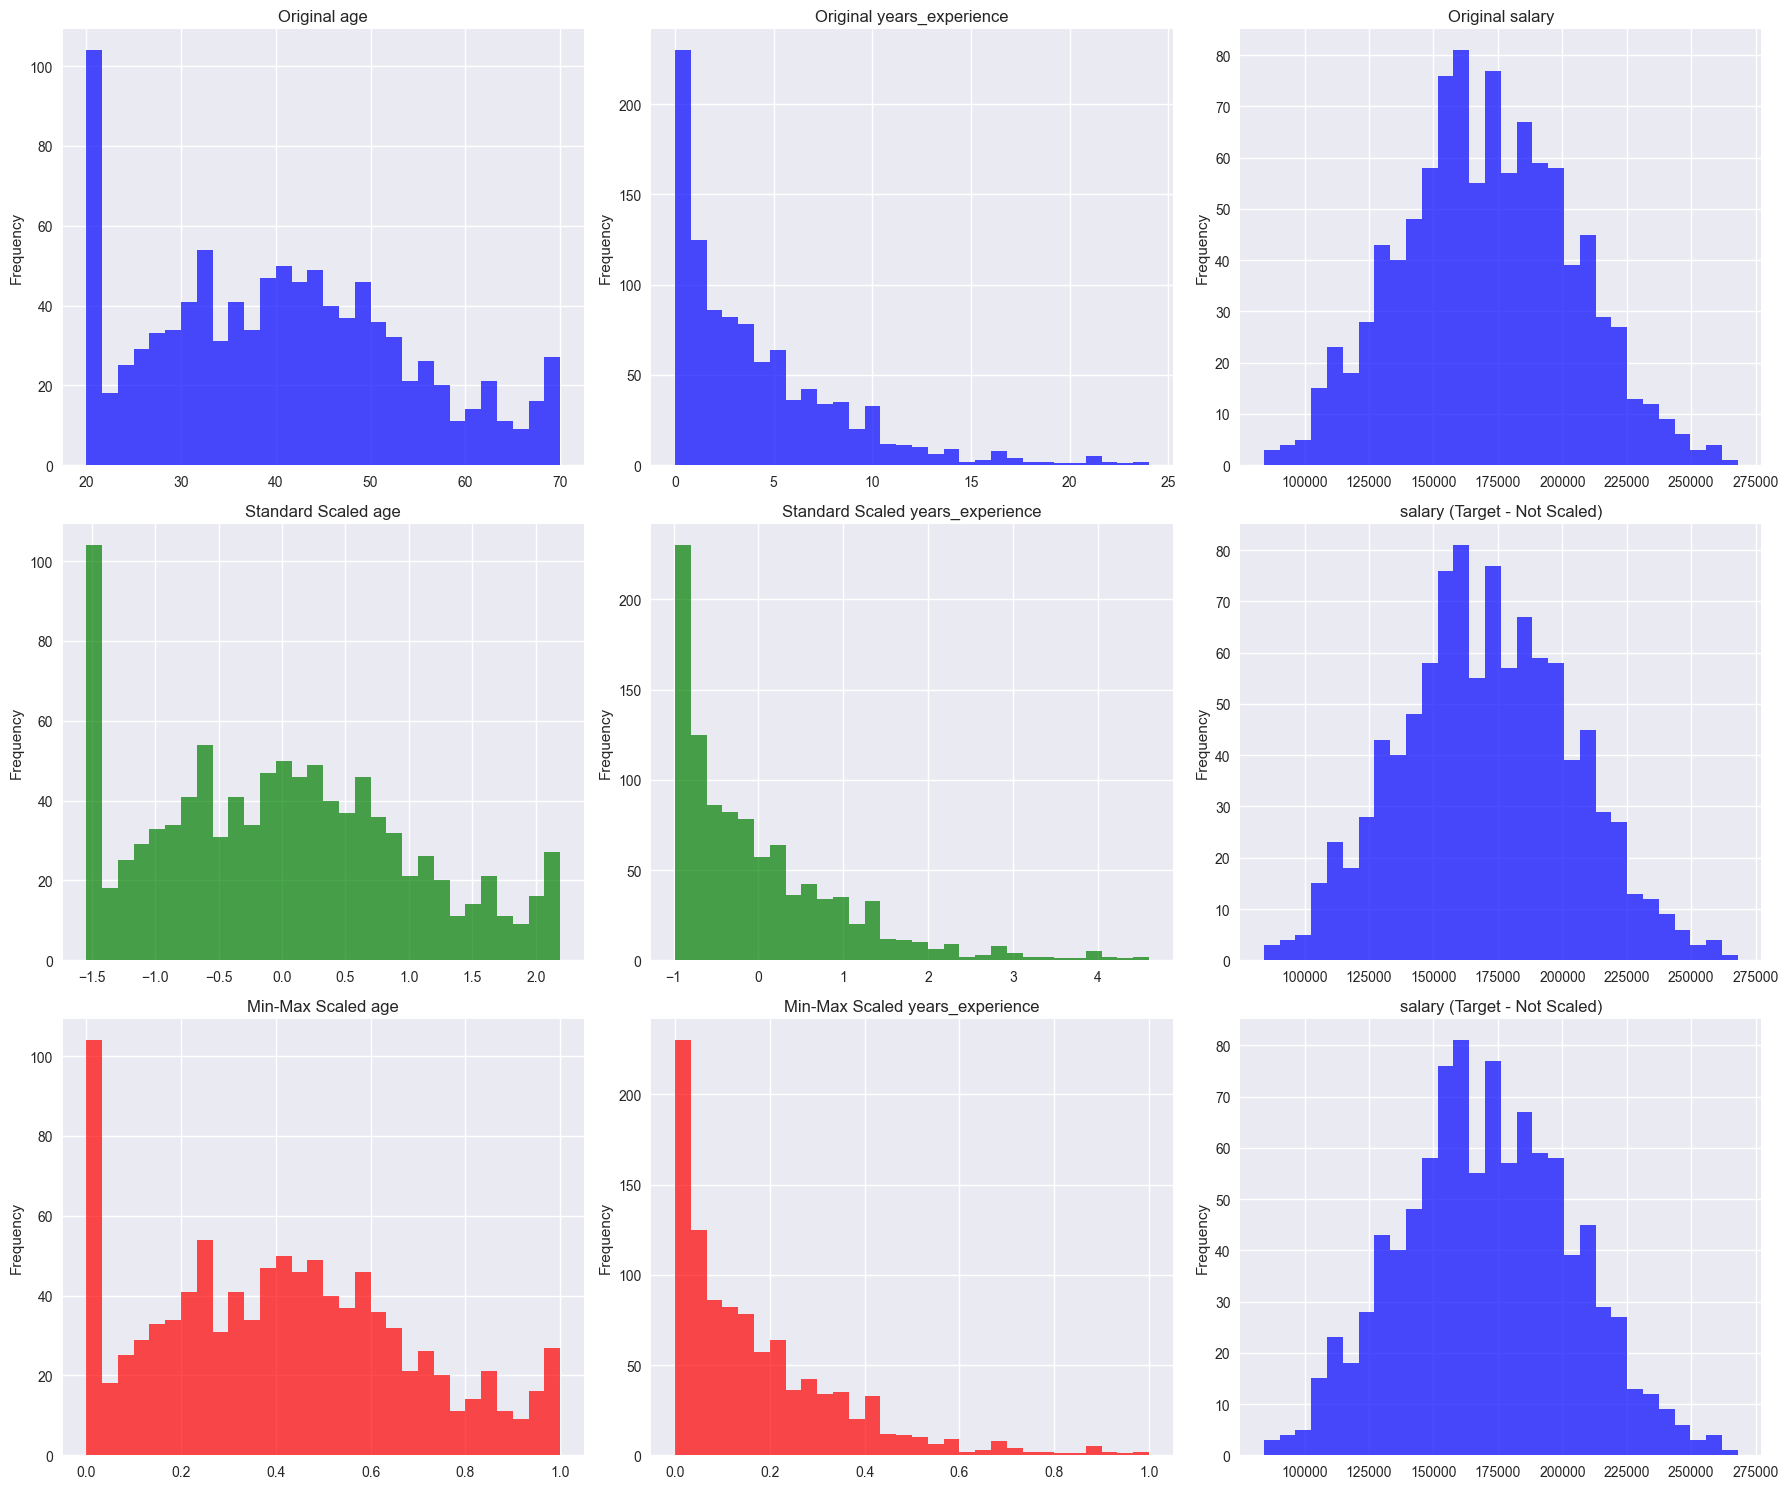

In [48]:
# Compare scaling methods
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Select a few key features for comparison
comparison_features = ['age', 'years_experience', 'salary']

for i, feature in enumerate(comparison_features):
    # Original
    axes[0, i].hist(df_processed[feature], bins=30, alpha=0.7, color='blue')
    axes[0, i].set_title(f'Original {feature}')
    axes[0, i].set_ylabel('Frequency')
    
    if feature != 'salary':  # Don't scale target variable
        # Standard scaled
        axes[1, i].hist(df_standard_scaled[feature], bins=30, alpha=0.7, color='green')
        axes[1, i].set_title(f'Standard Scaled {feature}')
        axes[1, i].set_ylabel('Frequency')
        
        # Min-max scaled
        axes[2, i].hist(df_minmax_scaled[feature], bins=30, alpha=0.7, color='red')
        axes[2, i].set_title(f'Min-Max Scaled {feature}')
        axes[2, i].set_ylabel('Frequency')
    else:
        # For salary, show the same distribution
        axes[1, i].hist(df_processed[feature], bins=30, alpha=0.7, color='blue')
        axes[1, i].set_title(f'{feature} (Target - Not Scaled)')
        axes[1, i].set_ylabel('Frequency')
        
        axes[2, i].hist(df_processed[feature], bins=30, alpha=0.7, color='blue')
        axes[2, i].set_title(f'{feature} (Target - Not Scaled)')
        axes[2, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 5: Outlier Detection and Treatment
Outliers can significantly impact model performance.

In [49]:
# Detect outliers using IQR method
def detect_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in key numerical columns
outlier_columns = ['hours_per_week', 'projects_completed', 'salary']

print("Outlier Detection Results:")
for col in outlier_columns:
    outliers, lower, upper = detect_outliers_iqr(df_processed, col)
    print(f"\n{col}:")
    print(f"  Normal range: {lower:.2f} to {upper:.2f}")
    print(f"  Outliers found: {len(outliers)} ({len(outliers)/len(df_processed)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  Outlier values: {sorted(outliers[col].values)[:5]}...")  # Show first 5

Outlier Detection Results:

hours_per_week:
  Normal range: 10.67 to 68.88
  Outliers found: 10 (1.0%)
  Outlier values: [np.float64(72.00518590064308), np.float64(73.03401561643003), np.float64(73.14018763722365), np.float64(73.22471112846135), np.float64(74.8576112054915)]...

projects_completed:
  Normal range: 2.00 to 18.00
  Outliers found: 16 (1.6%)
  Outlier values: [np.float64(19.0), np.float64(19.0), np.float64(20.0), np.float64(20.0), np.float64(22.0)]...

salary:
  Normal range: 78681.32 to 263249.80
  Outliers found: 1 (0.1%)
  Outlier values: [np.float64(268046.3915324057)]...


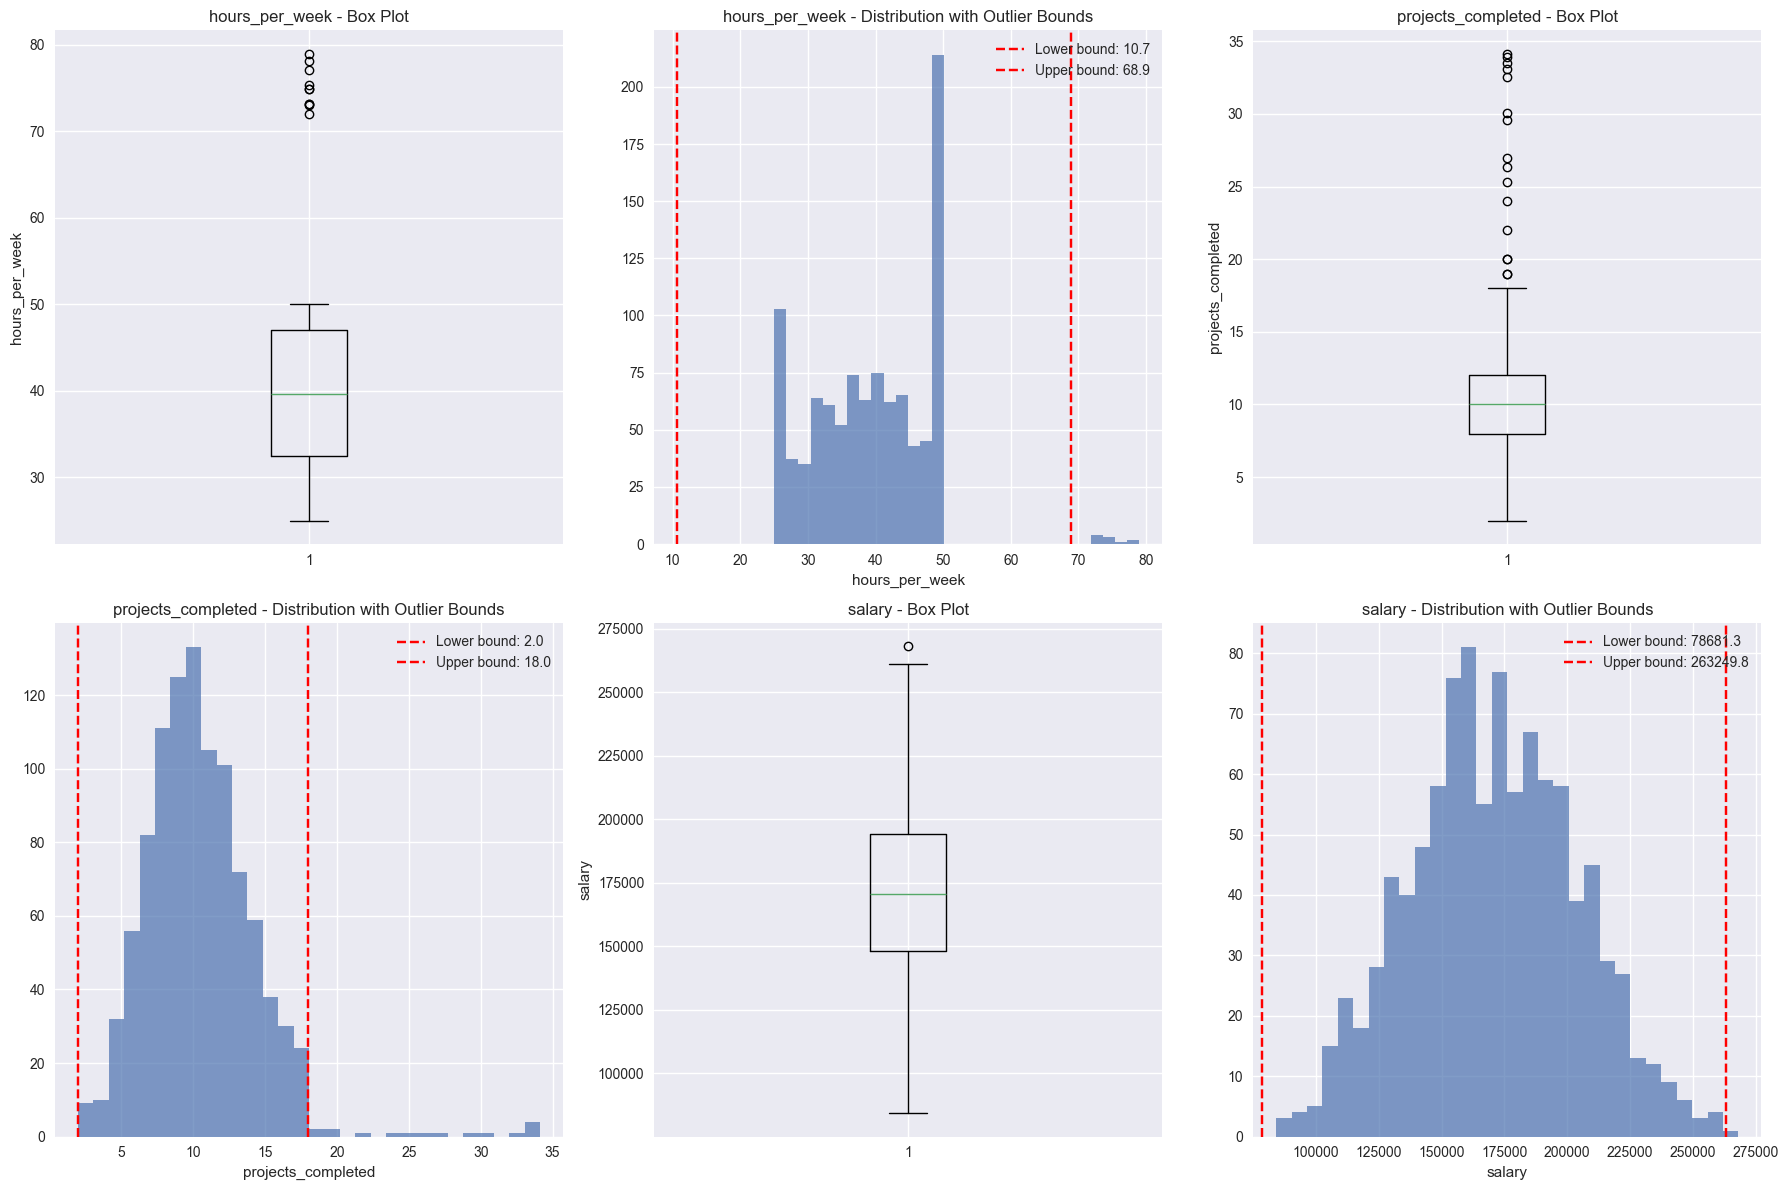

In [50]:
# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(outlier_columns):
    # Box plot
    axes[i*2].boxplot(df_processed[col])
    axes[i*2].set_title(f'{col} - Box Plot')
    axes[i*2].set_ylabel(col)
    
    # Histogram with outlier boundaries
    outliers, lower, upper = detect_outliers_iqr(df_processed, col)
    axes[i*2+1].hist(df_processed[col], bins=30, alpha=0.7)
    axes[i*2+1].axvline(lower, color='red', linestyle='--', label=f'Lower bound: {lower:.1f}')
    axes[i*2+1].axvline(upper, color='red', linestyle='--', label=f'Upper bound: {upper:.1f}')
    axes[i*2+1].set_title(f'{col} - Distribution with Outlier Bounds')
    axes[i*2+1].set_xlabel(col)
    axes[i*2+1].legend()

plt.tight_layout()
plt.show()

In [51]:
# Handle outliers - we'll use capping (Winsorization)
df_outlier_treated = df_processed.copy()

for col in outlier_columns:
    outliers, lower, upper = detect_outliers_iqr(df_processed, col)
    
    # Cap outliers at the bounds
    df_outlier_treated[col] = df_outlier_treated[col].clip(lower=lower, upper=upper)
    
    print(f"\n{col} outlier treatment:")
    print(f"  Values capped below {lower:.2f}: {len(df_processed[df_processed[col] < lower])}")
    print(f"  Values capped above {upper:.2f}: {len(df_processed[df_processed[col] > upper])}")

print("\nOutlier treatment completed using Winsorization (capping).")


hours_per_week outlier treatment:
  Values capped below 10.67: 0
  Values capped above 68.88: 10

projects_completed outlier treatment:
  Values capped below 2.00: 0
  Values capped above 18.00: 16

salary outlier treatment:
  Values capped below 78681.32: 0
  Values capped above 263249.80: 1

Outlier treatment completed using Winsorization (capping).


## Step 6: Feature Engineering
Creating new features that might be more predictive than the original ones.

In [52]:
# Create new features based on domain knowledge
df_engineered = df_outlier_treated.copy()

print("Creating new features...")

# 1. Experience-to-age ratio (career focus indicator)
df_engineered['experience_age_ratio'] = df_engineered['years_experience'] / df_engineered['age']

# 2. Productivity score (projects per year of experience)
df_engineered['productivity_score'] = df_engineered['projects_completed'] / (df_engineered['years_experience'] + 1)  # +1 to avoid division by zero

# 3. Work intensity (hours per week relative to standard 40)
df_engineered['work_intensity'] = df_engineered['hours_per_week'] / 40

# 4. Training investment (training hours per year of experience)
df_engineered['training_investment'] = df_engineered['training_hours'] / (df_engineered['years_experience'] + 1)

# 5. Performance-experience interaction
df_engineered['performance_experience'] = df_engineered['performance_score'] * df_engineered['years_experience']

# 6. Age groups (categorical feature from numerical)
df_engineered['age_group'] = pd.cut(df_engineered['age'], 
                                   bins=[0, 30, 40, 50, 100], 
                                   labels=['Young', 'Mid-Career', 'Experienced', 'Senior'])

# 7. Experience level (categorical feature from numerical)
df_engineered['experience_level'] = pd.cut(df_engineered['years_experience'], 
                                          bins=[0, 2, 5, 10, 100], 
                                          labels=['Novice', 'Intermediate', 'Experienced', 'Expert'])

# 8. High performer flag
df_engineered['high_performer'] = (df_engineered['performance_score'] > df_engineered['performance_score'].quantile(0.75)).astype(int)

print("New features created:")
new_features = ['experience_age_ratio', 'productivity_score', 'work_intensity', 
                'training_investment', 'performance_experience', 'age_group', 
                'experience_level', 'high_performer']
for feature in new_features:
    print(f"  • {feature}")

print(f"\nDataset shape after feature engineering: {df_engineered.shape}")

Creating new features...
New features created:
  • experience_age_ratio
  • productivity_score
  • work_intensity
  • training_investment
  • performance_experience
  • age_group
  • experience_level
  • high_performer

Dataset shape after feature engineering: (1003, 32)


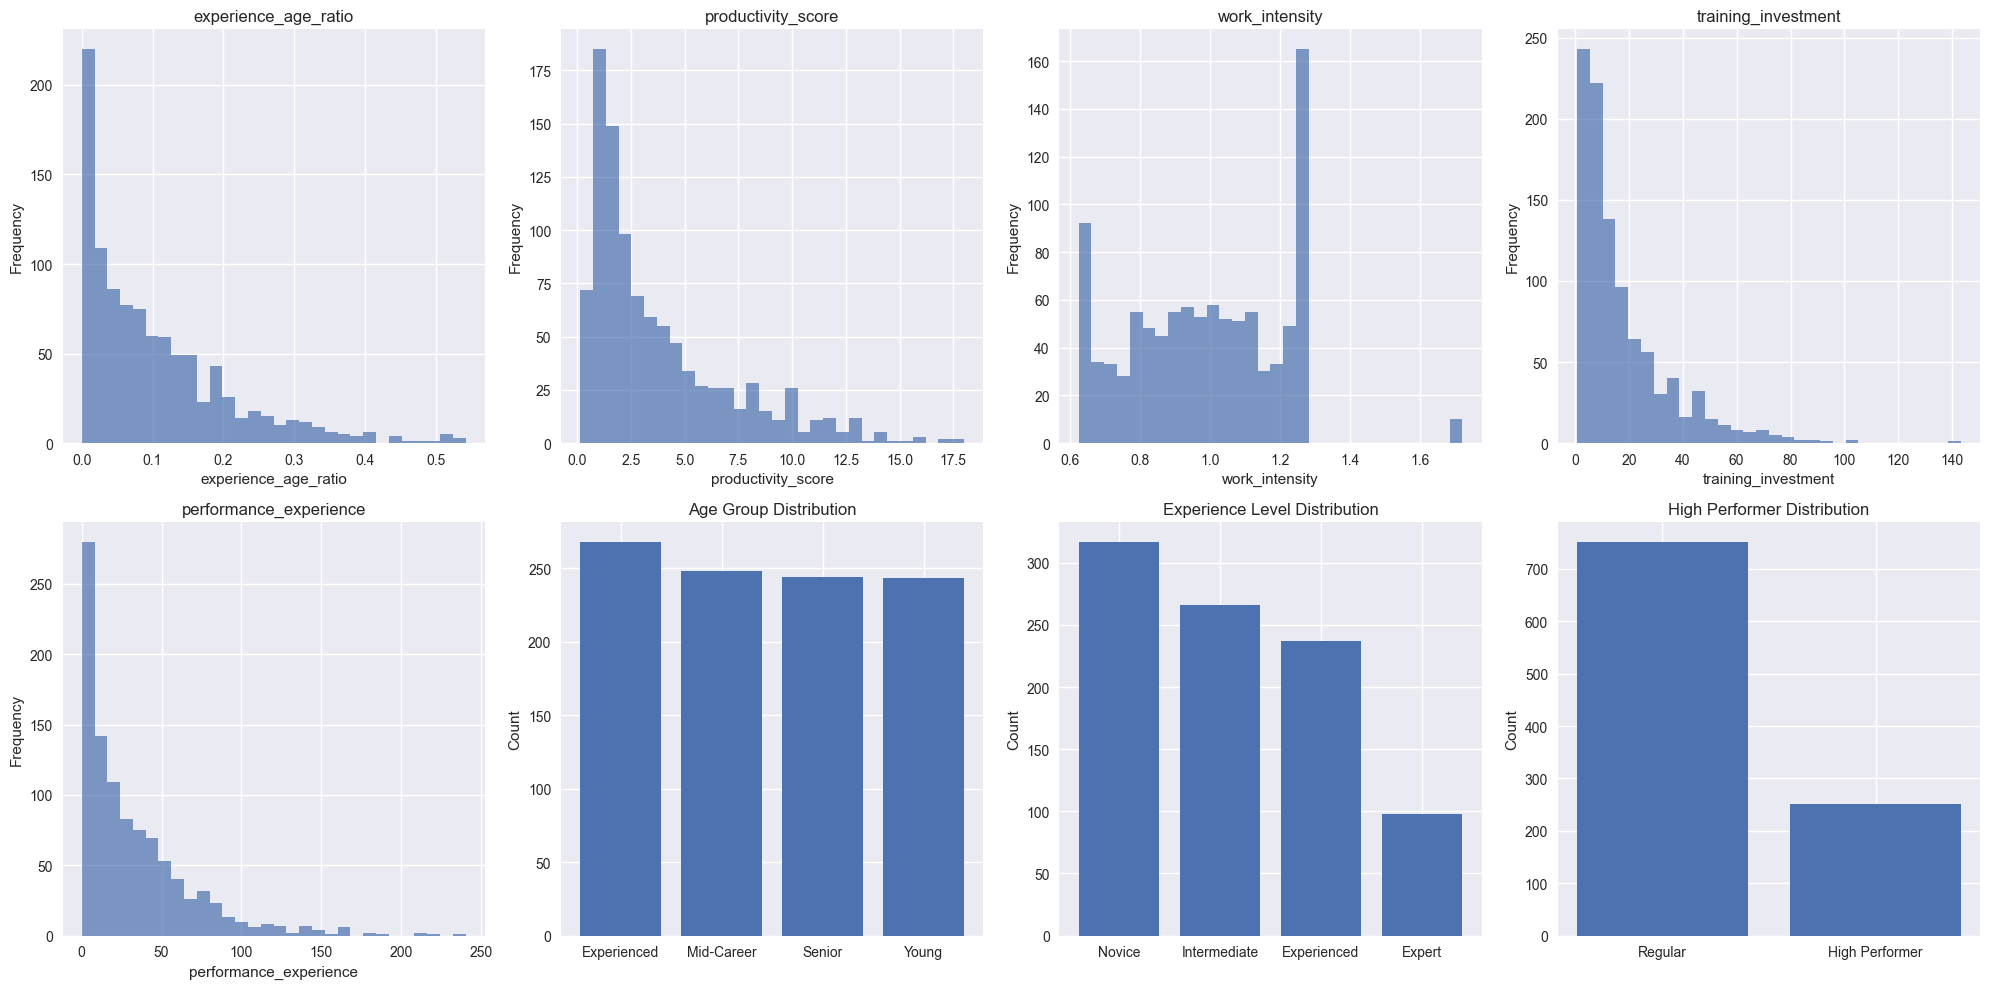

In [53]:
# Analyze the new features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

numerical_new_features = ['experience_age_ratio', 'productivity_score', 'work_intensity', 
                         'training_investment', 'performance_experience']

for i, feature in enumerate(numerical_new_features):
    axes[i].hist(df_engineered[feature], bins=30, alpha=0.7)
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Age group distribution
age_group_counts = df_engineered['age_group'].value_counts()
axes[5].bar(age_group_counts.index, age_group_counts.values)
axes[5].set_title('Age Group Distribution')
axes[5].set_ylabel('Count')

# Experience level distribution
exp_level_counts = df_engineered['experience_level'].value_counts()
axes[6].bar(exp_level_counts.index, exp_level_counts.values)
axes[6].set_title('Experience Level Distribution')
axes[6].set_ylabel('Count')

# High performer distribution
high_perf_counts = df_engineered['high_performer'].value_counts()
axes[7].bar(['Regular', 'High Performer'], high_perf_counts.values)
axes[7].set_title('High Performer Distribution')
axes[7].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Step 7: Feature Selection
Not all features are equally important. Let's identify the most predictive ones.

Feature Correlation with Salary (absolute values):
job_level_encoded          0.697
education_level_encoded    0.372
performance_experience     0.303
years_experience           0.291
experience_age_ratio       0.276
training_investment        0.205
productivity_score         0.199
performance_score          0.156
high_performer             0.134
training_hours             0.079
age                        0.067
projects_completed         0.018
work_intensity             0.007
hours_per_week             0.007
Name: salary, dtype: float64


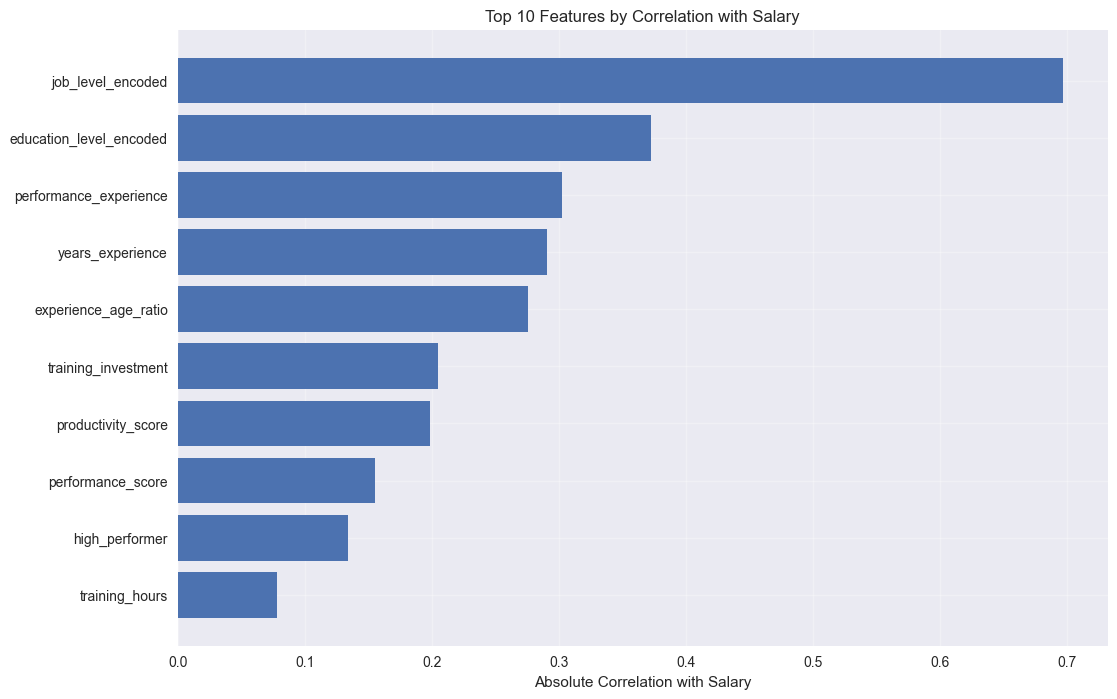

In [54]:
# Prepare data for feature importance analysis
# Select numerical features for correlation analysis
numerical_features_all = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID and target variable
numerical_features_all = [col for col in numerical_features_all if col not in ['employee_id', 'salary']]

# Calculate correlation with target variable (salary)
correlations = df_engineered[numerical_features_all + ['salary']].corr()['salary'].abs().sort_values(ascending=False)
correlations = correlations.drop('salary')  # Remove self-correlation

print("Feature Correlation with Salary (absolute values):")
print(correlations.round(3))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = correlations.head(10)
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Salary')
plt.title('Top 10 Features by Correlation with Salary')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()


Random Forest Feature Importance:
                    feature  importance
7         job_level_encoded      0.4877
6   education_level_encoded      0.1450
12   performance_experience      0.0637
2         performance_score      0.0576
8      experience_age_ratio      0.0367
11      training_investment      0.0345
9        productivity_score      0.0314
5            training_hours      0.0301
0                       age      0.0284
1          years_experience      0.0270
4        projects_completed      0.0209
3            hours_per_week      0.0176
10           work_intensity      0.0171
13           high_performer      0.0021


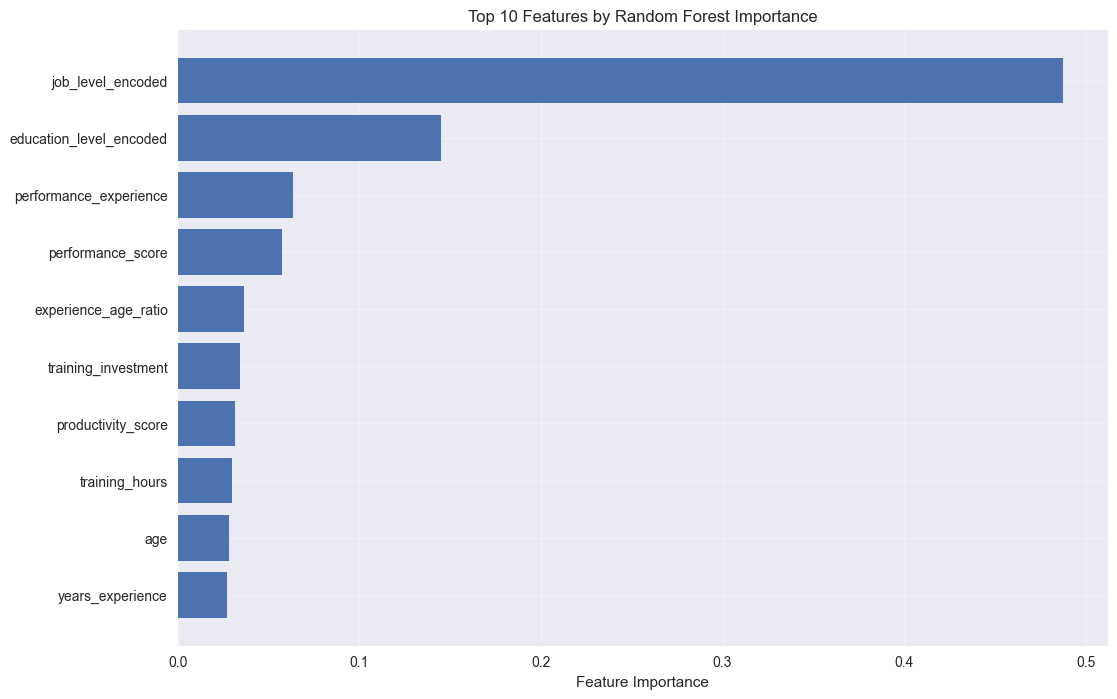

In [55]:
# Use Random Forest for feature importance
# Prepare features (only numerical for this example)
X = df_engineered[numerical_features_all]
y = df_engineered['salary']

# Train a Random Forest to get feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(feature_importance.round(4))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_rf_features = feature_importance.head(10)
plt.barh(range(len(top_rf_features)), top_rf_features['importance'])
plt.yticks(range(len(top_rf_features)), top_rf_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features by Random Forest Importance')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

## Step 8: Building a Preprocessing Pipeline
Let's create a reusable pipeline for all our preprocessing steps.

In [56]:
# Create a comprehensive preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define column groups
numerical_cols = ['age', 'years_experience', 'performance_score', 'hours_per_week', 
                 'projects_completed', 'training_hours']
categorical_cols = ['education_level', 'department', 'job_level', 'location']

# Create preprocessing pipelines for different column types
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

print("Preprocessing Pipeline Created:")
print("\nNumerical Pipeline:")
print("  1. Impute missing values with median")
print("  2. Standard scaling (mean=0, std=1)")
print("\nCategorical Pipeline:")
print("  1. Impute missing values with mode")
print("  2. One-hot encoding (drop first category)")

Preprocessing Pipeline Created:

Numerical Pipeline:
  1. Impute missing values with median
  2. Standard scaling (mean=0, std=1)

Categorical Pipeline:
  1. Impute missing values with mode
  2. One-hot encoding (drop first category)


In [57]:
# Test the pipeline on our data
# Start with original data (with missing values)
X_original = df[numerical_cols + categorical_cols]
y_original = df['salary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nMissing values in training set: {X_train.isnull().sum().sum()}")
print(f"Missing values in test set: {X_test.isnull().sum().sum()}")

# Apply preprocessing pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nAfter preprocessing:")
print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")
print(f"Missing values in processed training set: {np.isnan(X_train_processed).sum()}")
print(f"Missing values in processed test set: {np.isnan(X_test_processed).sum()}")

Training set shape: (802, 10)
Test set shape: (201, 10)

Missing values in training set: 146
Missing values in test set: 21

After preprocessing:
Training set shape: (802, 20)
Test set shape: (201, 20)
Missing values in processed training set: 0
Missing values in processed test set: 0


In [58]:
# Get feature names after preprocessing
# Numerical features keep their names
num_feature_names = numerical_cols

# Categorical features get expanded
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

all_feature_names = num_feature_names + list(cat_feature_names)

print(f"Total features after preprocessing: {len(all_feature_names)}")
print("\nFeature names:")
for i, name in enumerate(all_feature_names):
    print(f"  {i+1:2d}. {name}")

Total features after preprocessing: 20

Feature names:
   1. age
   2. years_experience
   3. performance_score
   4. hours_per_week
   5. projects_completed
   6. training_hours
   7. education_level_High School
   8. education_level_Master
   9. education_level_PhD
  10. department_Finance
  11. department_HR
  12. department_Marketing
  13. department_Sales
  14. job_level_Lead
  15. job_level_Mid
  16. job_level_Senior
  17. location_Chicago
  18. location_New York
  19. location_Remote
  20. location_San Francisco


## Challenge: Your Turn to Practice!
Now it's your turn to apply preprocessing techniques.

### Challenge 1: Create a new feature
Create a feature that represents "career progression speed" (job level encoded divided by years of experience). Handle the case where years of experience is 0.

In [ ]:
# Your code here for Challenge 1
# Hint: Use the job_level_encoded and years_experience columns


### Challenge 2: Handle a new categorical variable
Imagine we have a new column 'work_style' with values ['Remote', 'Hybrid', 'Office']. Add appropriate preprocessing for this column to our pipeline.

In [ ]:
# Your code here for Challenge 2
# Hint: You'll need to modify the categorical_cols list and recreate the preprocessor


### Challenge 3: Compare imputation strategies
Compare the effect of using mean vs median imputation for the 'performance_score' column. Which one preserves the distribution better?

In [ ]:
# Your code here for Challenge 3
# Hint: Create two versions of the data with different imputation strategies and compare histograms


## Summary

Congratulations! You've mastered the essential data preprocessing and feature engineering techniques. Here's what you've learned:

### ✅ Key Skills Mastered:
1. **Data Quality Assessment**: Identifying and understanding missing values, duplicates, and outliers
2. **Missing Value Handling**: Multiple imputation strategies (mean, median, mode, group-based)
3. **Categorical Encoding**: Ordinal encoding for ordered categories, one-hot encoding for nominal categories
4. **Feature Scaling**: StandardScaler and MinMaxScaler for different use cases
5. **Outlier Treatment**: Detection using IQR method and treatment using Winsorization
6. **Feature Engineering**: Creating new features from existing ones using domain knowledge
7. **Feature Selection**: Using correlation and Random Forest importance for feature ranking
8. **Pipeline Creation**: Building reusable preprocessing pipelines with scikit-learn

### 🔧 Best Practices Learned:
- Always understand your data before preprocessing
- Choose imputation strategies based on data distribution and missing patterns
- Use appropriate encoding for different types of categorical variables
- Scale features when algorithms are sensitive to feature magnitude
- Handle outliers based on domain knowledge and model requirements
- Create features that capture domain expertise
- Use pipelines to ensure reproducibility and prevent data leakage

### 🚀 Next Steps:
In the next lab, we'll use this preprocessed data to build and evaluate classification models, learning how to:
- Train logistic regression and decision tree classifiers
- Evaluate model performance using various metrics
- Use cross-validation for robust model assessment
- Interpret model results and make predictions

### 📚 Additional Resources:
- [Scikit-learn Preprocessing Guide](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Feature Engineering Techniques](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)
- [Handling Missing Data](https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda70d4dd536)
- [Pipeline Documentation](https://scikit-learn.org/stable/modules/compose.html)